In [1]:
### Multi-class Predictions in Pytorch
# Setup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import os

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

PyTorch version: 2.8.0
NumPy version: 2.0.2
Pandas version: 2.3.3


In [2]:
# Set your working directory (for one above the notebooks directory)
os.chdir("..")

# Verify current directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/tardis/Library/CloudStorage/GoogleDrive-natrdn@gmail.com/My Drive/Natália (Academic Folder)/Post_doc/ML_pred_scRNA


In [3]:
#Load and prepare data
data = anndata.read_h5ad('data/my_dataset_small.h5ad')

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Original data shape: {data.shape}")
print(f"Cells: {data.n_obs}, Genes: {data.n_vars}")

# Normalize (same as Day 1)
sc.pp.normalize_total(data, target_sum=1e6)
sc.pp.log1p(data)

# Filter genes (same as Day 1)
mean_expr = np.array(data.X.mean(axis=0)).flatten()
gene_filter = mean_expr > 0.1
data = data[:, gene_filter].copy()

print(f"\nAfter filtering:")
print(f"Data shape: {data.shape}")
print(f"Cells: {data.n_obs}, Genes: {data.n_vars}")

DATA LOADING
Original data shape: (2988, 33159)
Cells: 2988, Genes: 33159

After filtering:
Data shape: (2988, 13080)
Cells: 2988, Genes: 13080


In [4]:
# Keep all cell types (Multi-class)
# Day 3: Do NOT filter to just two cell types
# Use all cells and all author-defined cell types

print("\n" + "=" * 60)
print("CELL TYPE INFORMATION")
print("=" * 60)
print(f"Cell type distribution:")
print(data.obs.author_cell_type.value_counts())

num_cell_types = data.obs.author_cell_type.nunique()
print(f"\nTotal number of cell types: {num_cell_types}")


CELL TYPE INFORMATION
Cell type distribution:
author_cell_type
Neurons - glutamatergic upper layer 3                  451
Neurons - glutamatergic upper layer 1                  313
Neurons - glutamatergic deep layer, epithelial-like    310
Neurons - glutamatergic deep layer 2                   271
Astrocytes                                             264
Neurons - glutamatergic deep layer 3                   259
Neuroblasts - NHLH1 1                                  196
Neurons - glutamatergic upper layer 2                  192
Neuroblasts - NHLH1 2                                  177
Glioblasts                                             176
Neuroblasts - NHLH2                                    136
Neurons - glutamatergic deep layer 1                   136
Neurons - GABAergic                                    107
Name: count, dtype: int64

Total number of cell types: 13


In [6]:
### Set up pytorch tensors
# Convert input to Pytorch Tensor
# For the input, we need a dense numpy matrix
X = torch.Tensor(data.X.todense())

# Scale AFTER creating the tensor (Day 2 logic reused in Day 3)
# Scaling function (must be defined BEFORE use)
def scale(x):
    """
    Scale features (genes) to have mean=0 and std=1.
    """
    m = x.mean(axis=0, keepdim=True)
    s = x.std(axis=0, unbiased=False, keepdim=True)
    x = x - m
    x = x / s
    return x
    
X = scale(X)

print("\n" + "=" * 60)
print("INPUT TENSOR (X)")
print("=" * 60)
print(f"X shape: {X.shape}")
print(f"X dtype: {X.dtype}")
print(f"\nFirst 5 cells, first 5 genes:")
print(X[:5, :5])


INPUT TENSOR (X)
X shape: torch.Size([2988, 13080])
X dtype: torch.float32

First 5 cells, first 5 genes:
tensor([[-0.2200,  1.0122,  5.3406, -0.3154, -0.2115],
        [-0.2200,  0.7603, -0.2543,  2.9204, -0.2115],
        [ 4.2794,  1.4997, -0.2543, -0.3154, -0.2115],
        [-0.2200,  1.4369, -0.2543, -0.3154, -0.2115],
        [-0.2200,  1.0389, -0.2543,  3.4693, -0.2115]])


In [7]:
# Convert output to Pytorch tensor (One-hot encoding - Multi-Class)
# For the output, we need one-hot encoding of ALL cell types
# This creates a matrix with shape [num_cells, num_cell_types]
# Each row has exactly one 1 (the true cell type) and zeros elsewhere

# Step 1: Use get_dummies() to create one column per cell type
y_df_bool = pd.get_dummies(data.obs["author_cell_type"])

print("\n" + "=" * 60)
print("ONE-HOT ENCODING")
print("=" * 60)
print(f"get_dummies output (boolean):")
print(y_df_bool.head())
print(f"Shape: {y_df_bool.shape}")

# Step 2: Add 0 to convert boolean to numeric {0, 1}
y_df = y_df_bool + 0

print(f"\nAfter adding 0 (numeric):")
print(y_df.head())

# Step 3: Convert to numpy
y_np = y_df.to_numpy()

print(f"\nNumPy array shape: {y_np.shape}")
print(f"First 5 rows (one-hot encoded):")
print(y_np[:5])

# Step 4: Convert to PyTorch tensor
Y = torch.Tensor(y_np)

print("\n" + "=" * 60)
print("OUTPUT TENSOR (Y) - ONE-HOT")
print("=" * 60)
print(f"Y shape: {Y.shape}  # cells × cell types")
print(f"Y dtype: {Y.dtype}")
print(f"Unique values in Y: {torch.unique(Y)}")
print(f"\nFirst 10 rows of Y:")
print(Y[:10])


ONE-HOT ENCODING
get_dummies output (boolean):
                                 Astrocytes  Glioblasts  \
CellID                                                    
10X310_2_AB_1:CCGTGAGAGAGCGACTx       False       False   
10X310_2_AB_1:TTCCACGCACTCCCTAx       False       False   
10X310_2_AB_1:TTCAGGACATGACGGAx       False       False   
10X310_1_AB_1:CCAAGCGGTCCCTCATx       False       False   
10X310_2_AB_1:TCGGGACGTAGCTGCCx       False       False   

                                 Neuroblasts - NHLH1 1  Neuroblasts - NHLH1 2  \
CellID                                                                          
10X310_2_AB_1:CCGTGAGAGAGCGACTx                  False                  False   
10X310_2_AB_1:TTCCACGCACTCCCTAx                  False                  False   
10X310_2_AB_1:TTCAGGACATGACGGAx                  False                  False   
10X310_1_AB_1:CCAAGCGGTCCCTCATx                  False                  False   
10X310_2_AB_1:TCGGGACGTAGCTGCCx                  Fal

In [8]:
# Store key dimensions
num_cells, num_celltypes = Y.shape
input_dim = X.shape[1]
num_classes = num_celltypes

print(f"\nKey dimensions saved:")
print(f"  num_cells: {num_cells}")
print(f"  num_celltypes: {num_celltypes}")
print(f"  input_dim (genes): {input_dim}")
print(f"  num_classes: {num_classes}")



Key dimensions saved:
  num_cells: 2988
  num_celltypes: 13
  input_dim (genes): 13080
  num_classes: 13


In [9]:
# Define ML Model
class MultiClassNN(nn.Module):
    """
    Simple multi-class neural network:
    - Linear layer 1: input_dim -> 50
    - ReLU activation
    - Linear layer 2: 50 -> num_classes
    
    Important: NO softmax in the model.
    CrossEntropyLoss will apply softmax internally.
    """
    def __init__(self, input_dim, num_classes):
        super(MultiClassNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, num_classes)  # outputs logits
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # logits - no softmax here!
        return x

print("\n" + "=" * 60)
print("MODEL DEFINITION")
print("=" * 60)
print("✓ MultiClassNN class defined with:")
print("  - Linear layer 1: input_dim -> 50")
print("  - ReLU activation")
print("  - Linear layer 2: 50 -> num_classes")
print("  - NO softmax (CrossEntropyLoss handles it)")


MODEL DEFINITION
✓ MultiClassNN class defined with:
  - Linear layer 1: input_dim -> 50
  - ReLU activation
  - Linear layer 2: 50 -> num_classes
  - NO softmax (CrossEntropyLoss handles it)


In [10]:
### Model and learning setup
# Initialize model
model = MultiClassNN(input_dim=input_dim, num_classes=num_classes)

print("\n" + "=" * 60)
print("MODEL INITIALIZATION")
print("=" * 60)
print(f"Input dimension: {input_dim}")
print(f"Number of classes: {num_classes}")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")


MODEL INITIALIZATION
Input dimension: 13080
Number of classes: 13

Model architecture:
MultiClassNN(
  (fc1): Linear(in_features=13080, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=13, bias=True)
)

Total parameters: 654,713


In [11]:
# Define loss function for multi-class
# CrossEntropyLoss for multi-class classification
# It expects:
# - logits (not probabilities) with shape [batch_size, num_classes]
# - class indices (not one-hot) with shape [batch_size]
# It applies softmax internally

criterion = nn.CrossEntropyLoss()

print("\n" + "=" * 60)
print("LOSS FUNCTION")
print("=" * 60)
print(f"Criterion: {criterion}")
print("Note: CrossEntropyLoss combines softmax and cross-entropy loss")
print("Expects: logits [N, C] and class indices [N]")


LOSS FUNCTION
Criterion: CrossEntropyLoss()
Note: CrossEntropyLoss combines softmax and cross-entropy loss
Expects: logits [N, C] and class indices [N]


In [12]:
# Prepare targets for CrossEntropyLoss
# CrossEntropyLoss expects class indices (0, 1, 2, ..., num_classes-1)
# not one-hot encoding. Convert Y from one-hot to class indices.

y_class_index = torch.argmax(Y, dim=1)  # shape: [num_cells]

print("\n" + "=" * 60)
print("TARGET CONVERSION")
print("=" * 60)
print(f"Original Y shape (one-hot): {Y.shape}")
print(f"Class indices shape: {y_class_index.shape}")
print(f"\nFirst 20 class indices:")
print(y_class_index[:20])
print(f"\nClass distribution (should match one-hot):")
for i in range(num_classes):
    count = (y_class_index == i).sum().item()
    print(f"  Class {i}: {count} cells")


TARGET CONVERSION
Original Y shape (one-hot): torch.Size([2988, 13])
Class indices shape: torch.Size([2988])

First 20 class indices:
tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10])

Class distribution (should match one-hot):
  Class 0: 264 cells
  Class 1: 176 cells
  Class 2: 196 cells
  Class 3: 177 cells
  Class 4: 136 cells
  Class 5: 107 cells
  Class 6: 136 cells
  Class 7: 271 cells
  Class 8: 259 cells
  Class 9: 310 cells
  Class 10: 313 cells
  Class 11: 192 cells
  Class 12: 451 cells


In [13]:
# Define optimizer (learning rate 0.1)
# Adam optimizer with learning rate 0.1
optimizer = optim.Adam(model.parameters(), lr=0.1)

print("\n" + "=" * 60)
print("OPTIMIZER")
print("=" * 60)
print(f"Optimizer: {optimizer}")
print(f"Learning rate: 0.1")


OPTIMIZER
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)
Learning rate: 0.1


In [14]:
# Look at initial weights
# Look at the weights of the layers
print("\n" + "=" * 60)
print("INITIAL WEIGHTS")
print("=" * 60)
print(f"fc1 weight shape: {model.fc1.weight.shape}")
print(f"fc2 weight shape: {model.fc2.weight.shape}")
print(f"\nFirst 5 weights from fc1:")
print(model.fc1.weight.data[0, :5])
print(f"\nfc1 bias (first 5):")
print(model.fc1.bias.data[:5])


INITIAL WEIGHTS
fc1 weight shape: torch.Size([50, 13080])
fc2 weight shape: torch.Size([13, 50])

First 5 weights from fc1:
tensor([-0.0003, -0.0013, -0.0028, -0.0009, -0.0041])

fc1 bias (first 5):
tensor([ 0.0062, -0.0021,  0.0015, -0.0039, -0.0019])


In [15]:
### My sanity check - Assess Performance (Before Training)
# Apply the model to the data (one forward pass)
outputs = model(X)

print("\n" + "=" * 60)
print("FORWARD PASS (before training)")
print("=" * 60)
print(f"Outputs shape: {outputs.shape}  # [num_cells, num_classes]")
print(f"Outputs dtype: {outputs.dtype}")
print(f"\nFirst 5 output rows (logits):")
print(outputs[:5])
print(f"\nOutput value range:")
print(f"  Min: {outputs.min().item():.4f}")
print(f"  Max: {outputs.max().item():.4f}")


FORWARD PASS (before training)
Outputs shape: torch.Size([2988, 13])  # [num_cells, num_classes]
Outputs dtype: torch.float32

First 5 output rows (logits):
tensor([[-0.4322, -0.2892,  0.4222,  0.1673,  0.6910,  0.0032, -0.1397, -0.1982,
         -0.1339, -0.2758,  0.2380, -0.4348, -0.2625],
        [-0.2864, -0.3742,  0.0186,  0.1070,  0.1730,  0.0666,  0.2148, -0.4407,
         -0.0345, -0.2359,  0.0391, -0.7258, -0.2329],
        [ 0.2449, -0.0852, -0.2838,  0.5271, -0.0998,  0.1861, -0.1163, -0.2743,
         -0.0310,  0.1735, -0.0823, -0.6253, -0.2230],
        [-0.0792,  0.0621, -0.0085,  0.3200, -0.1355,  0.0858, -0.1136, -0.2223,
         -0.0682,  0.1471,  0.0847, -0.5184, -0.2450],
        [ 0.2461, -0.1315, -0.4059,  0.0896,  0.0078,  0.2302,  0.0101, -0.4135,
          0.0150, -0.0162,  0.2633, -0.5052, -0.4643]],
       grad_fn=<SliceBackward0>)

Output value range:
  Min: -1.5066
  Max: 1.1445


In [16]:
# Calculate loss compared to true labels
loss = criterion(outputs, y_class_index)

print("\n" + "=" * 60)
print("LOSS CALCULATION")
print("=" * 60)
print(f"Loss (before training): {loss.item():.4f}")


LOSS CALCULATION
Loss (before training): 2.5865


In [17]:
# Calculate accuracy
# Step 1: Get predicted class (argmax of logits)
preds = torch.argmax(outputs, dim=1)

# Step 2: Compare with true class
correct = (preds == y_class_index).float()

# Step 3: Calculate accuracy
accuracy = correct.mean().item()

print("\n" + "=" * 60)
print("ACCURACY CALCULATION")
print("=" * 60)
print(f"First 20 predictions: {preds[:20]}")
print(f"First 20 true labels:  {y_class_index[:20]}")
print(f"\nNumber correct: {correct.sum().item():.0f} / {len(y_class_index)}")
print(f"Accuracy (before training): {accuracy:.4f} ({accuracy*100:.2f}%)")


ACCURACY CALCULATION
First 20 predictions: tensor([ 4,  6,  3,  3, 10,  3,  9,  4,  3, 10,  3,  3,  3,  4,  9,  3,  9,  9,
         5,  3])
First 20 true labels:  tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10])

Number correct: 233 / 2988
Accuracy (before training): 0.0780 (7.80%)


In [18]:
### Training with Learning Rate (lr) 0.1
print("\n" + "=" * 60)
print("TRAINING - Learning Rate 0.1")
print("=" * 60)

# Reinitialize model for clean training
model = MultiClassNN(input_dim=input_dim, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

num_epochs = 50
loss_list_lr_01 = []
acc_list_lr_01 = []

for epoch in range(1, num_epochs + 1):
    # Training step
    model.train()
    outputs = model(X)
    loss = criterion(outputs, y_class_index)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss
    loss_list_lr_01.append(loss.item())
    
    # Calculate accuracy
    model.eval()
    with torch.no_grad():
        logits = model(X)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y_class_index).float().mean().item()
        acc_list_lr_01.append(acc)
    
    # Print progress
    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch [{epoch:02d}/{num_epochs}] | Loss: {loss.item():.4f} | Acc: {acc:.4f}")

print("\n✓ Training complete!")
print(f"Final loss: {loss_list_lr_01[-1]:.4f}")
print(f"Final accuracy: {acc_list_lr_01[-1]:.4f} ({acc_list_lr_01[-1]*100:.2f}%)")


TRAINING - Learning Rate 0.1
Epoch [01/50] | Loss: 2.6152 | Acc: 0.3481
Epoch [05/50] | Loss: 85.5432 | Acc: 0.4796
Epoch [10/50] | Loss: 13.4149 | Acc: 0.8819
Epoch [15/50] | Loss: 4.1836 | Acc: 0.9926
Epoch [20/50] | Loss: 0.5861 | Acc: 0.9997
Epoch [25/50] | Loss: 0.0010 | Acc: 1.0000
Epoch [30/50] | Loss: 0.0000 | Acc: 1.0000
Epoch [35/50] | Loss: 0.0000 | Acc: 1.0000
Epoch [40/50] | Loss: 0.0000 | Acc: 1.0000
Epoch [45/50] | Loss: 0.0000 | Acc: 1.0000
Epoch [50/50] | Loss: 0.0000 | Acc: 1.0000

✓ Training complete!
Final loss: 0.0000
Final accuracy: 1.0000 (100.00%)


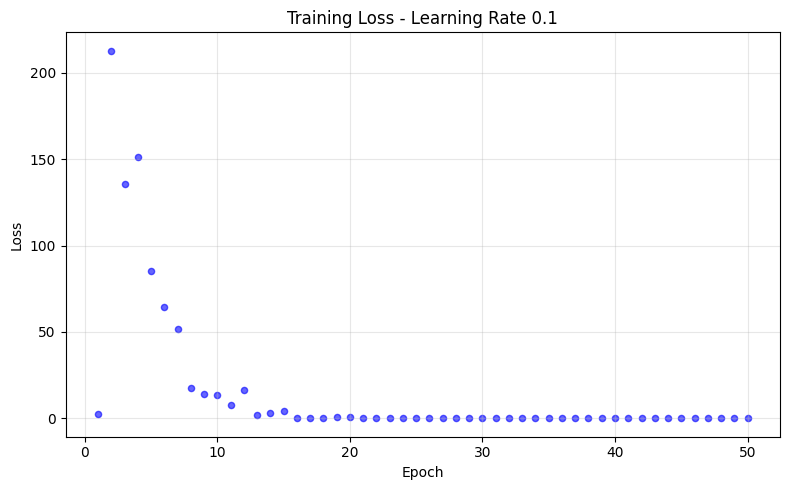

✓ Loss plot saved as 'day3_loss_lr01.png'


In [19]:
# Visual - Scatterplot of loss (lf = 0.1)
# Visualize loss over epochs
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.scatter(epochs, loss_list_lr_01, s=20, alpha=0.6, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - Learning Rate 0.1')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('day3_loss_lr01.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Loss plot saved as 'day3_loss_lr01.png'")

In [20]:
### Training with Learning rate 0.01
# Retrain from scratch (different lr)
print("\n" + "=" * 60)
print("TRAINING - Learning Rate 0.01")
print("=" * 60)

# Reinitialize model with same architecture but different learning rate
model_lr_001 = MultiClassNN(input_dim=input_dim, num_classes=num_classes)
criterion_lr_001 = nn.CrossEntropyLoss()
optimizer_lr_001 = optim.Adam(model_lr_001.parameters(), lr=0.01)

loss_list_lr_001 = []
acc_list_lr_001 = []

for epoch in range(1, num_epochs + 1):
    # Training step
    model_lr_001.train()
    outputs = model_lr_001(X)
    loss = criterion_lr_001(outputs, y_class_index)
    
    optimizer_lr_001.zero_grad()
    loss.backward()
    optimizer_lr_001.step()
    
    # Store loss
    loss_list_lr_001.append(loss.item())
    
    # Calculate accuracy
    model_lr_001.eval()
    with torch.no_grad():
        logits = model_lr_001(X)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y_class_index).float().mean().item()
        acc_list_lr_001.append(acc)
    
    # Print progress
    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch [{epoch:02d}/{num_epochs}] | Loss: {loss.item():.4f} | Acc: {acc:.4f}")

print("\n✓ Training complete!")
print(f"Final loss: {loss_list_lr_001[-1]:.4f}")
print(f"Final accuracy: {acc_list_lr_001[-1]:.4f} ({acc_list_lr_001[-1]*100:.2f}%)")


TRAINING - Learning Rate 0.01
Epoch [01/50] | Loss: 2.6107 | Acc: 0.5228
Epoch [05/50] | Loss: 1.3064 | Acc: 0.9063
Epoch [10/50] | Loss: 0.1734 | Acc: 0.9920
Epoch [15/50] | Loss: 0.0108 | Acc: 0.9990
Epoch [20/50] | Loss: 0.0060 | Acc: 0.9997
Epoch [25/50] | Loss: 0.0007 | Acc: 1.0000
Epoch [30/50] | Loss: 0.0003 | Acc: 1.0000
Epoch [35/50] | Loss: 0.0001 | Acc: 1.0000
Epoch [40/50] | Loss: 0.0001 | Acc: 1.0000
Epoch [45/50] | Loss: 0.0001 | Acc: 1.0000
Epoch [50/50] | Loss: 0.0000 | Acc: 1.0000

✓ Training complete!
Final loss: 0.0000
Final accuracy: 1.0000 (100.00%)


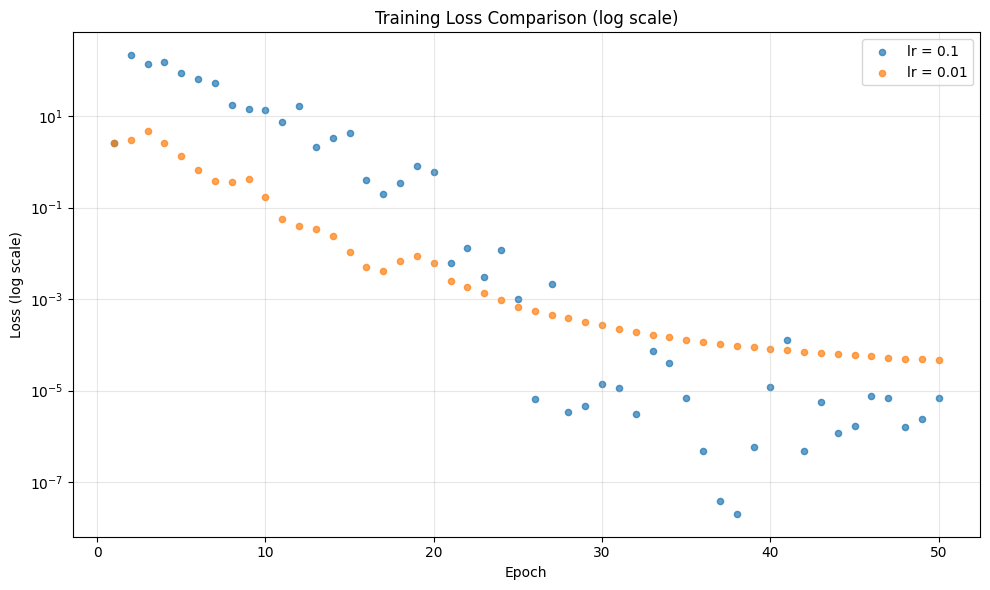

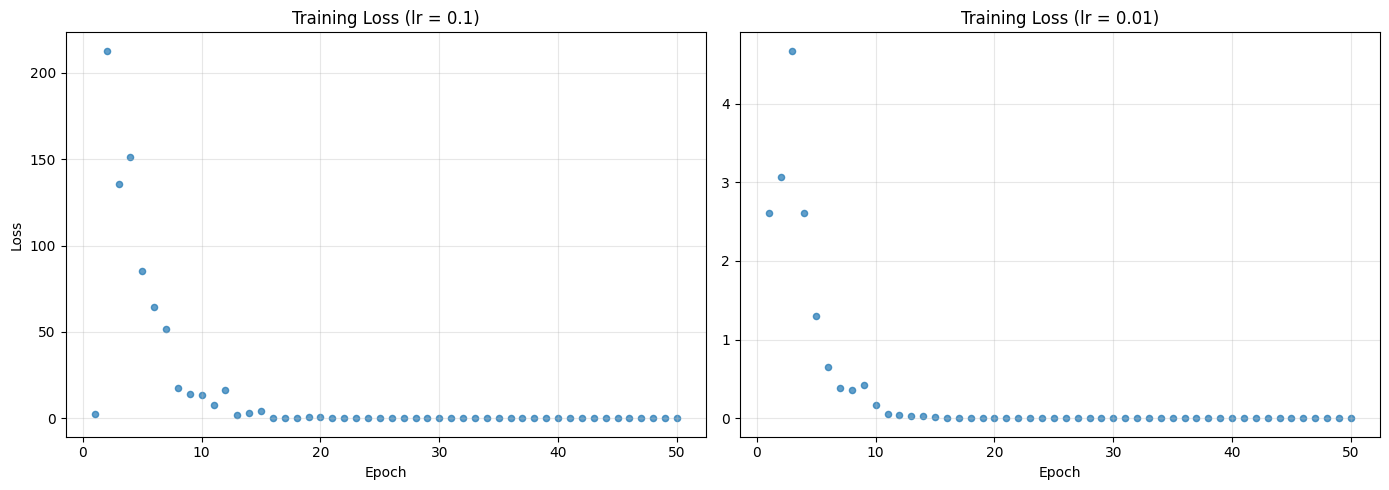

In [22]:
# ============================
# VISUALIZATION OF LOSS CURVES
# ============================

epochs = np.arange(1, num_epochs + 1)

# --------------------------------------------------
# OPTION 1: Plot both learning rates together (LOG SCALE)
# --------------------------------------------------
plt.figure(figsize=(10, 6))

plt.scatter(epochs, loss_list_lr_01, s=20, alpha=0.7, label="lr = 0.1")
plt.scatter(epochs, loss_list_lr_001, s=20, alpha=0.7, label="lr = 0.01")

plt.yscale("log")  # <<< KEY LINE
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss Comparison (log scale)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()


# --------------------------------------------------
# OPTION 2: Plot learning rates separately (linear scale)
# --------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# lr = 0.1
axes[0].scatter(epochs, loss_list_lr_01, s=20, alpha=0.7)
axes[0].set_title("Training Loss (lr = 0.1)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)

# lr = 0.01
axes[1].scatter(epochs, loss_list_lr_001, s=20, alpha=0.7)
axes[1].set_title("Training Loss (lr = 0.01)")
axes[1].set_xlabel("Epoch")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()